# 手写 Transformer

In [1]:
import torch
from torch import nn
import torch.functional as F

import math

In [2]:
X = torch.randn(128, 64, 512) # [batch, time, dimension]

In [3]:
print(X.shape)

torch.Size([128, 64, 512])


## 多头注意力机制

In [4]:
d_model = 512 # q,k,v 权重dim 
n_head = 8 # 注意力头

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head) -> None:
        super(MultiHeadAttention, self).__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_combine = nn.Linear(d_model, d_model)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, mask = None):
        batch, time, dimension = q.shape
        n_d = self.d_model // self.n_head
        
        q = self.w_q(q)
        k = self.w_k(k) 
        v = self.w_v(v)

        q = q.view(batch, time, self.n_head, n_d).permute(0, 2, 1, 3)
        k = k.view(batch, time, self.n_head, n_d).permute(0, 2, 1, 3)
        v = v.view(batch, time, self.n_head, n_d).permute(0, 2, 1, 3)
        
        score = q @ k.transpose(2,3) / math.sqrt(n_d)
        if mask is not None:
            mask = torch.tril(torch.ones(time, time, dtype=bool))
            score = score.masked_fill(mask == 0, float("-inf")) # 做 softmax 操作时，e 的负五无穷等于 0
        score = self.softmax(score) @ v

        score = score.permute(0, 2, 1, 3).contiguous().view(batch, time, dimension)

        output = self.w_combine(score)
        return output

In [6]:
attention = MultiHeadAttention(d_model, n_head)
output = attention(X,X,X, mask = 1)
print(output)
print(output.shape)

tensor([[[ 1.7265e-01,  1.6188e-01, -7.5981e-01,  ..., -3.1275e-01,
          -1.6714e-01, -2.5387e-01],
         [ 1.9728e-01,  3.4671e-02, -2.5558e-01,  ..., -3.2360e-01,
           9.0759e-02, -8.5331e-02],
         [ 2.3413e-01, -6.3415e-02, -2.6489e-01,  ..., -2.5318e-01,
          -4.2335e-02,  1.1987e-01],
         ...,
         [ 2.8990e-02,  8.2040e-03, -3.2846e-02,  ..., -7.3900e-02,
           5.5674e-02,  1.6047e-02],
         [ 7.2968e-03,  3.7421e-02, -3.6473e-02,  ..., -6.4435e-02,
           6.2402e-02, -2.4118e-02],
         [ 4.1899e-03,  2.0969e-02, -3.7268e-02,  ..., -9.5517e-02,
           6.9181e-02,  3.3863e-02]],

        [[ 4.7616e-01,  1.0603e-01,  2.1978e-01,  ..., -2.7685e-01,
           2.6547e-01,  4.3940e-01],
         [ 5.3534e-01,  5.0547e-02, -4.3890e-03,  ..., -3.0607e-01,
           1.0421e-01,  1.7598e-01],
         [ 3.8932e-01,  7.8689e-03,  8.3642e-02,  ..., -2.2974e-01,
           5.5306e-02,  3.0868e-01],
         ...,
         [ 2.5229e-02,  1

## Token Embedding

In [ ]:
class TokenEmbedding(nn.Embedding):
    def __init__(self, vocab_size, d_model) -> None:
        super(TokenEmbedding, self).__init__(vocab_size, d_model, padding_idx= 1)

## Position Embedding

奇数和偶数有不同的 sin 和 cos 编码

In [ ]:
class PositionalEnbedding(nn.Module):
    def __init__(self, d_model, maxlen, device) -> None:
        super(PositionalEnbedding, self).__init__()
        self.encoding = torch.zeros(maxlen, d_model, device)
        self.encoding.requires_grad_(False)

        pos = torch.arange(0, maxlen, device)
        pos = pos.float().unsqueeze(1)
        _2i = torch.arange(0, d_model, 2, device)

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 0::1] = torch.cos(pos / (10000 ** (_2i / d_model)))

    def forward(self, x):
        seq_len = x.shape[1]
        return self.encoding[:seq_len, :]


## LayerNorm 层归一化

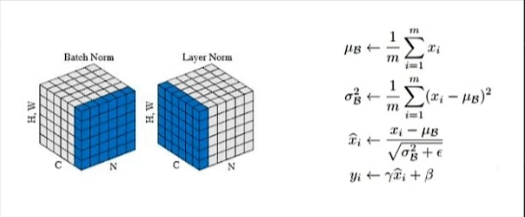

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-10) -> None:
        super(PositionalEnbedding, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim = True)
        var = x.var(-1, unbiased= False, keepdim = True)
        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta
        return out

## FFN

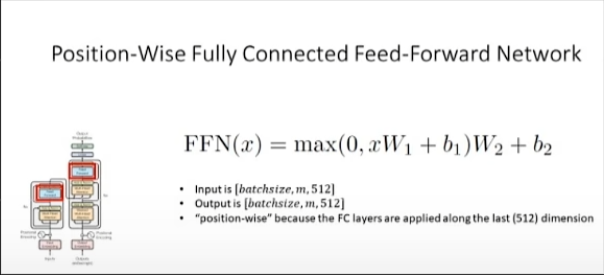

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, dropout=0.6) -> None:
        super(PositionWiseFeedForward, self).__init__()

        self.fc1 = nn.Linear(d_model, hidden)
        self.fc2 = nn.Linear(hidden, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


## Encoder Layer

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, n_head, dropout) -> None:
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model, n_head)
        self.norm1 = LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

        self.ffn = PositionWiseFeedForward(d_model, ffn_hidden, dropout)
        self.norm2 = LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask = None):
        _x = x
        x = self.attention(x, x, x, mask = mask)
        x = self.dropout1(x)
        x = self.norm1(x + _x)

        _x = x
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + _x)
        
        return x


